<a href="https://colab.research.google.com/github/reza-pishva/1-SchoolProject-Php-Laravel/blob/main/clustering_comp_brg_vib_mitsubishi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score, silhouette_samples
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import scipy.cluster.hierarchy as sch
import warnings # Ignore specific warnings
warnings.filterwarnings("ignore")

In [157]:
df1 = pd.read_csv('dsas11_comp_brg_vib.csv')

In [158]:
filtered_df = df1[(df1['Job'] == 'Operation') & (df1['IsDeleted'] == 0) & (df1['ValueType'] == 1)]
df1 = filtered_df.drop(columns=['PersonelID', 'MobileID', 'Job', 'IsDeleted','OutofRange','ValueType','UnitID','OnTime'])
df1.head()

,ID,AssetID,Value,RecordTime,RecordDate,DateTime,TimeStamp,ShiftCode
6,1055890,9360,17.0,12:04:42,2021/03/19,2021-03-19 12:04:42.000,1616142882,12
7,1055891,9361,25.0,12:04:44,2021/03/19,2021-03-19 12:04:44.000,1616142884,12
8,1057877,9360,16.0,21:16:45,2021/03/20,2021-03-20 21:16:45.000,1616262405,12
9,1057878,9361,22.0,21:16:47,2021/03/20,2021-03-20 21:16:47.000,1616262407,12
10,1057991,9360,16.0,23:21:16,2021/03/20,2021-03-20 23:21:16.000,1616269876,12


In [159]:
number_of_rows = df1.shape[0]
print("Number of rows:", number_of_rows)

Number of rows: 14278


In [160]:
df2 = pd.read_csv('systems.csv')

In [161]:
# Merge df1 and df2 on AssetId
merged = pd.merge(df1, df2, on='AssetID', how='inner')

# Remove duplicates based on AssetId
unique_asset_descriptions = merged.drop_duplicates(subset='AssetID')

# Display the resulting DataFrame
# display(HTML(merged[['ShiftCode','DateTime','AssetID','Sys','Description','Value']].to_html(max_rows=100)))


In [162]:
# Merge df1 and df2 on AssetId
merged_df = pd.merge(df1, df2, on='AssetID')

# Drop the AssetId column
result_df = merged_df.drop(columns=['KKS','MeasurementUnit','StartTime','DateTime','Version','Type',
                                    'AssetRange','ShowCondition','SequenceShow','Activation','AssetTag','ActiveTimeTag','ActivationTag','IsDeleted',
                                    'EditTime','RangeLL','RangeHH','RangeBol1','RangeBol2','RangeBol3','RangeBol4','NumType','Conditions','LTShort'])

In [163]:
# AssetIDs to check
asset_ids_to_check = [9360,9361]

# Filter the DataFrame to include only the specified AssetIDs
filtered_df = result_df[result_df['AssetID'].isin(asset_ids_to_check)]

# Initialize a list to keep track of valid ShiftCodes
valid_shiftcodes = []

# Iterate through each ShiftCode and check the count of each AssetID
for shift_code in filtered_df['ShiftCode'].unique():
    shift_code_df = filtered_df[filtered_df['ShiftCode'] == shift_code]
    asset_count = shift_code_df['AssetID'].value_counts()

    if all(asset_count == 4):
        valid_shiftcodes.append(shift_code)

# Filter the original DataFrame to keep only the rows with valid ShiftCodes
result_df = result_df[result_df['ShiftCode'].isin(valid_shiftcodes)]
result_df['AssetID'].value_counts()

,count
AssetID,
9360,5244
9361,5244


In [164]:
def plot_and_display(asset_id , date1 , date2):
    # Filter the DataFrame for the given AssetID
    filtered_df = result_df[result_df['AssetID'] == asset_id]

    # Combine RecordDate and RecordTime into a single datetime column
    filtered_df['DateTime'] = pd.to_datetime(filtered_df['RecordDate'] + ' ' + filtered_df['RecordTime'])

    # Sort the DataFrame by DateTime
    filtered_df = filtered_df.sort_values(by='DateTime')

    # Filter the DataFrame for the first month of 2022
    filtered_df = filtered_df[(filtered_df['DateTime'] >= date1) & (filtered_df['DateTime'] <= date2)]

    filtered_df['Value'].hist()

    # Display the DataFrame as HTML
    display(HTML(filtered_df[['ShiftCode','RecordDate', 'RecordTime', 'Description','Sys','Value']].to_html(max_rows=None)))

    # Plot the data
    plt.figure(figsize=(6,4))
    plt.plot(filtered_df['DateTime'], filtered_df['Value'], marker='o', linestyle='-')
    plt.xlabel('DateTime')
    plt.ylabel('Value')
    plt.title(f'Value vs. DateTime for January 2022 - AssetID {asset_id}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [165]:
def df_preparing(asset_id1 ,asset_id2,date1 , date2):
    # Filter the DataFrame for the given AssetID
    filtered_df1 = result_df[result_df['AssetID'] == asset_id1]
    filtered_df2 = result_df[result_df['AssetID'] == asset_id2]
    # filtered_df3 = result_df[result_df['AssetID'] == asset_id3]
    # filtered_df4 = result_df[result_df['AssetID'] == asset_id4]


    # Combine RecordDate and RecordTime into a single datetime column
    filtered_df1['DateTime'] = pd.to_datetime(filtered_df1['RecordDate'] + ' ' + filtered_df1['RecordTime'])
    filtered_df2['DateTime'] = pd.to_datetime(filtered_df2['RecordDate'] + ' ' + filtered_df2['RecordTime'])
    # filtered_df3['DateTime'] = pd.to_datetime(filtered_df3['RecordDate'] + ' ' + filtered_df3['RecordTime'])
    # filtered_df4['DateTime'] = pd.to_datetime(filtered_df4['RecordDate'] + ' ' + filtered_df4['RecordTime'])



    # Sort the DataFrame by DateTime
    filtered_df1 = filtered_df1.sort_values(by='DateTime')
    filtered_df2 = filtered_df2.sort_values(by='DateTime')
    # filtered_df3 = filtered_df3.sort_values(by='DateTime')
    # filtered_df4 = filtered_df4.sort_values(by='DateTime')


    # Filter the DataFrame for the first month of 2022
    lube_oil_df1 = filtered_df1[(filtered_df1['DateTime'] >= date1) & (filtered_df1['DateTime'] <= date2)]
    lube_oil_df2 = filtered_df2[(filtered_df2['DateTime'] >= date1) & (filtered_df2['DateTime'] <= date2)]
    # lube_oil_df3 = filtered_df3[(filtered_df3['DateTime'] >= date1) & (filtered_df3['DateTime'] <= date2)]
    # lube_oil_df4 = filtered_df4[(filtered_df4['DateTime'] >= date1) & (filtered_df4['DateTime'] <= date2)]


    # Display the DataFrame as HTML
    number_of_rows1 = lube_oil_df1.shape[0]
    number_of_rows2 = lube_oil_df2.shape[0]
    # number_of_rows3 = lube_oil_df3.shape[0]
    # number_of_rows4 = lube_oil_df4.shape[0]


    lube_oil_df1.dropna(subset=['Value'])
    lube_oil_df2.dropna(subset=['Value'])
    # lube_oil_df3.dropna(subset=['Value'])
    # lube_oil_df4.dropna(subset=['Value'])


    print("Number of rows1:", number_of_rows1)
    print("Number of rows2:", number_of_rows2)
    # print("Number of rows3:", number_of_rows3)
    # print("Number of rows4:", number_of_rows4)


    # Ensure both DataFrames are properly indexed
    df1 = lube_oil_df1.reset_index(drop=True)
    df2 = lube_oil_df2.reset_index(drop=True)
    # df3 = lube_oil_df3.reset_index(drop=True)
    # df4 = lube_oil_df4.reset_index(drop=True)

    # Create a new DataFrame by concatenating the 'Value' columns from each DataFrame
    combined_df = pd.concat([df1['Value'], df2['Value']], axis=1)
    print("Number of concat rows:", combined_df.shape[0])
    # Rename the columns
    combined_df.columns = ['COMP BRG VIB (JOURNAL) X',
                           'COMP BRG VIB (JOURNAL) Y']



    return combined_df

In [166]:
df = df_preparing(9360 ,9361,'2022-01-01','2024-01-10')
# Convert specific columns to numeric
df['COMP BRG VIB (JOURNAL) X'] = pd.to_numeric(df['COMP BRG VIB (JOURNAL) X'])
df['COMP BRG VIB (JOURNAL) Y'] = pd.to_numeric(df['COMP BRG VIB (JOURNAL) Y'])


Number of rows1: 4038
Number of rows2: 4038
Number of concat rows: 4038


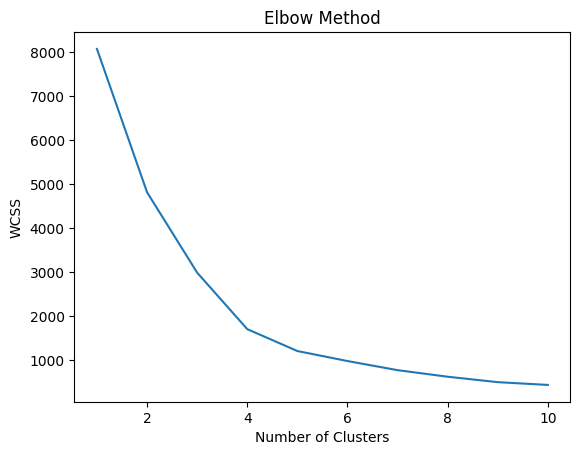

In [167]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply KMeans for different numbers of clusters and compute WCSS
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

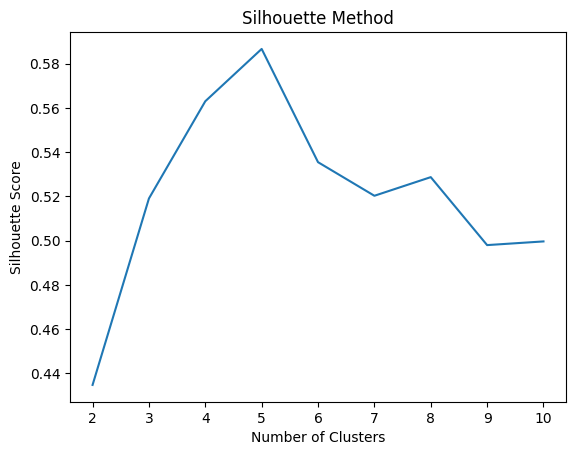

In [168]:
# Apply KMeans for different numbers of clusters and compute silhouette scores
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette scores
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method')
plt.show()

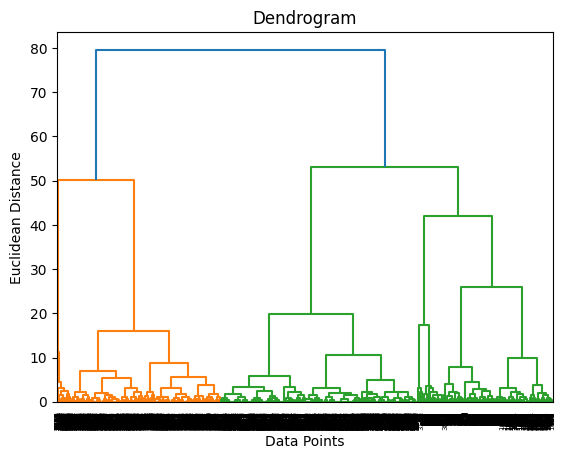

In [169]:
# Create the dendrogram
dendrogram = sch.dendrogram(sch.linkage(scaled_data, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

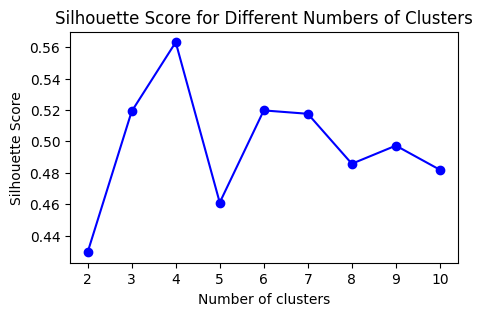

In [170]:
def evaluate_silhouette(df, max_clusters=10):
    silhouette_scores = []

    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(df)
        silhouette_avg = silhouette_score(df, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    return silhouette_scores

# Parameters
max_clusters = 10
silhouette_scores = evaluate_silhouette(scaled_data, max_clusters)

# Plot the Silhouette scores
plt.figure(figsize=(5, 3))
plt.plot(range(2, max_clusters + 1), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

Average Silhouette Score: 0.5631081918571824


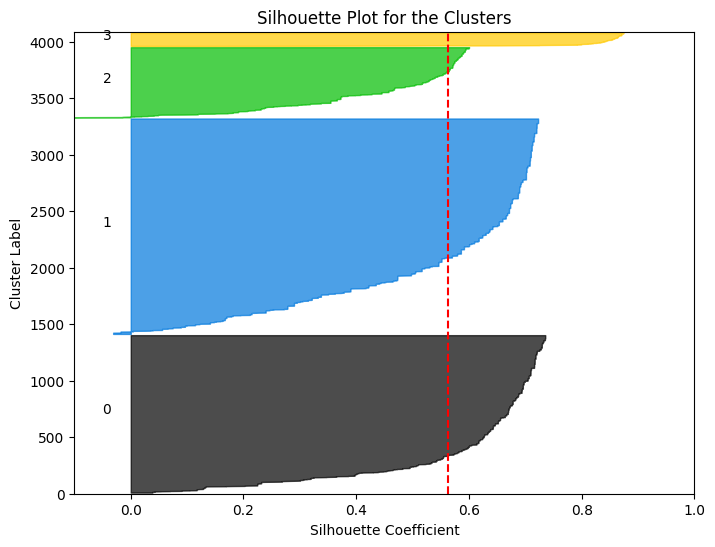

<Figure size 500x400 with 0 Axes>

In [171]:
# Number of clusters for KMeans
n_clusters = 4

# Apply KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_data)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg}")

# Calculate the Silhouette Coefficients for each sample
sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

# Create the Silhouette Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# Set limits for the plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

# Initialize the y-axis position
y_lower = 10

for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

# Plot the average silhouette score as a vertical line
plt.figure(figsize=(5, 4))
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Silhouette Plot for the Clusters")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
plt.show()


Average Silhouette Score: 0.5570686383141092


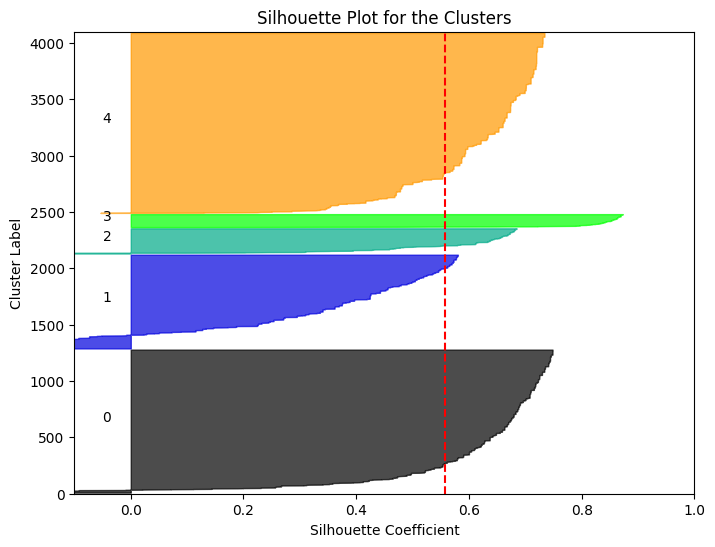

<Figure size 500x400 with 0 Axes>

In [172]:
# Number of clusters for KMeans
n_clusters = 5

# Apply GaussianMixture clustering
gmm = GaussianMixture(n_components=5, random_state=42)
cluster_labels = gmm.fit_predict(scaled_data)

# Calculate the Silhouette Score
silhouette_avg = silhouette_score(scaled_data, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg}")

# Calculate the Silhouette Coefficients for each sample
sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

# Create the Silhouette Plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# Set limits for the plot
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_data) + (n_clusters + 1) * 10])

# Initialize the y-axis position
y_lower = 10

for i in range(n_clusters):
    # Aggregate silhouette scores for samples in cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10

# Plot the average silhouette score as a vertical line
plt.figure(figsize=(5, 4))
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_title("Silhouette Plot for the Clusters")
ax1.set_xlabel("Silhouette Coefficient")
ax1.set_ylabel("Cluster Label")
plt.show()

In [173]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(scaled_data)

# Add cluster labels to the original DataFrame
df['Cluster'] = clusters
dbscan.labels_


array([0, 0, 0, ..., 0, 0, 0])

In [174]:
# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts().sort_values(ascending=False)

# Convert to DataFrame for better visualization
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']

print(cluster_counts_df)


   Cluster  Count
0        0   3873
1        4    110
2        2     36
3        1      8
4       -1      8
5        3      3


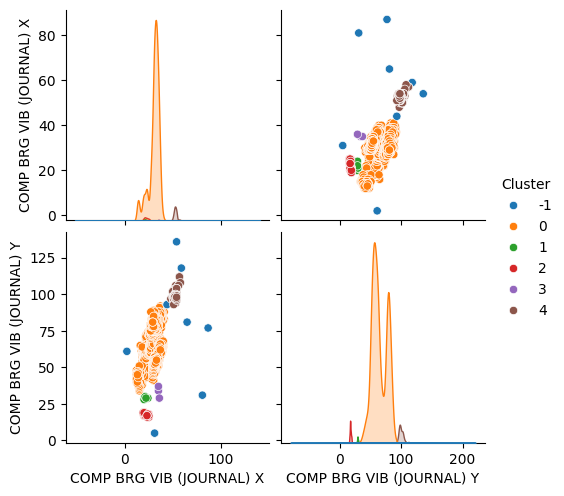

In [175]:
# Ensure the columns for the pairplot are specified correctly
vars_to_plot = df.columns[:-1]  # All columns except 'Cluster'

# Visualize the clusters using pair plot
sns.pairplot(df, hue='Cluster', palette='tab10', vars=vars_to_plot)
plt.show()


In [176]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df['COMP.BRG.Rel.VIBR.'],
#            df['COMP.BRG.Abs.VIBR.'],
#            df['TURB.BRG.Rel.VIBR.'], c=df['Cluster'], cmap='tab10')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.title('DBSCAN Clustering')
# plt.show()

In [177]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [178]:
# Apply Hierarchical Clustering with 4 clusters
hierarchical_clustering = AgglomerativeClustering(n_clusters=4)
clusters = hierarchical_clustering.fit_predict(scaled_data)

# Add cluster labels to the original DataFrame
df['Cluster'] = clusters

In [179]:
# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Convert to DataFrame for better visualization
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']

print(cluster_counts_df)


   Cluster  Count
0        0    631
1        1   1224
2        2   2073
3        3    110


In [180]:
# Apply Isolation Forest
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_Score'] = isolation_forest.fit_predict(scaled_data)
df[df['Anomaly_Score']==-1].shape[0]


201

In [181]:

gmm = GaussianMixture(n_components=4, random_state=42)
clusters = gmm.fit_predict(scaled_data)
# Add cluster labels to the original DataFrame
df['Cluster'] = clusters
# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Convert to DataFrame for better visualization
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']

print(cluster_counts_df)

   Cluster  Count
0        0   2276
1        1   1597
2        2     55
3        3    110


In [182]:
gmm = GaussianMixture(n_components=5, random_state=42)
clusters = gmm.fit_predict(scaled_data)
# Add cluster labels to the original DataFrame
df['Cluster'] = clusters
# Count the number of data points in each cluster
cluster_counts = df['Cluster'].value_counts().sort_index()

# Convert to DataFrame for better visualization
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ['Cluster', 'Count']

print(cluster_counts_df)

   Cluster  Count
0        0   1161
1        1   1595
2        2   1117
3        3    110
4        4     55


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.6233
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0402
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0126
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0042
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - loss: 0.0020
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 0.0015
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 6.2849e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 5.6694e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 4.4267e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 4.0559e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 7.5027e-04
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - loss: 0.0023
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0025
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0021
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms

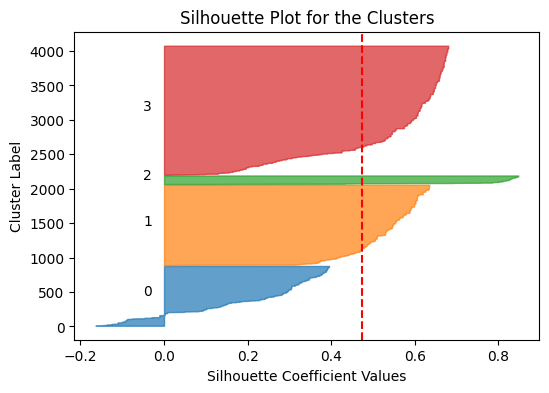

In [183]:
# Convert data to numeric, if necessary
df = df.apply(pd.to_numeric, errors='coerce')

# Handle any NaN values resulting from the conversion
df.fillna(0, inplace=True)

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df)

# Define the autoencoder architecture
input_dim = data_normalized.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(500, activation='relu')(input_layer)
encoder = Dense(500, activation='relu')(encoder)
encoder = Dense(2000, activation='relu')(encoder)
latent_space = Dense(10, activation='linear')(encoder)
decoder = Dense(2000, activation='relu')(latent_space)
decoder = Dense(500, activation='relu')(decoder)
decoder = Dense(500, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder model
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized, data_normalized, epochs=50, batch_size=256, shuffle=True)

# Extract the encoder part of the model
encoder_model = Model(inputs=input_layer, outputs=latent_space)

# Obtain the latent space representation of the data
encoded_data = encoder_model.predict(data_normalized)

# Initialize the clusters using KMeans
n_clusters = 4  # Number of clusters you want to find
kmeans = KMeans(n_clusters=n_clusters)
kmeans_clusters = kmeans.fit_predict(encoded_data)

# Output the clusters and their counts
df['cluster'] = kmeans_clusters
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print(cluster_counts.sort_values('Cluster'))

# Silhouette Plot
silhouette_avg = silhouette_score(encoded_data, kmeans_clusters)
print(f"Average Silhouette Score: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(encoded_data, kmeans_clusters)

plt.figure(figsize=(6, 4))
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[kmeans_clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = sns.color_palette()[i]
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for the Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.show()

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.6430
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0646
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0244
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0149
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0058
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0029
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0045
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - loss: 0.0024
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - loss: 0.0013
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 0.0011
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0011
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 7.3417e-04
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 5.1317e-04
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 4.2710e-04
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - 

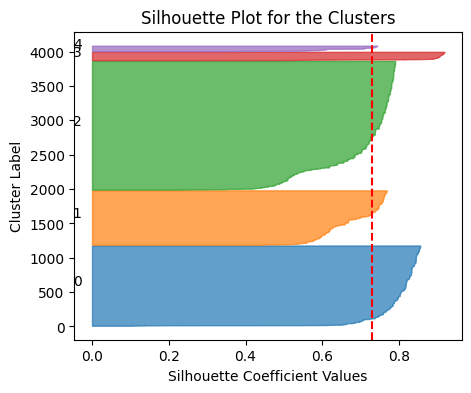

In [184]:
# Checking and converting data to numeric
df = df.apply(pd.to_numeric, errors='coerce')
df.fillna(0, inplace=True)

# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(df)

# Define the autoencoder architecture
input_dim = data_normalized.shape[1]
input_layer = Input(shape=(input_dim,))
encoder = Dense(500, activation='relu')(input_layer)
encoder = Dense(500, activation='relu')(encoder)
encoder = Dense(2000, activation='relu')(encoder)
latent_space = Dense(10, activation='linear')(encoder)
decoder = Dense(2000, activation='relu')(latent_space)
decoder = Dense(500, activation='relu')(decoder)
decoder = Dense(500, activation='relu')(decoder)
output_layer = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(data_normalized, data_normalized, epochs=50, batch_size=256, shuffle=True)

# Extract the encoder part of the model
encoder_model = Model(inputs=input_layer, outputs=latent_space)
encoded_data = encoder_model.predict(data_normalized)

# Initialize the clusters using KMeans
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters)
kmeans_clusters = kmeans.fit_predict(encoded_data)

# Define clustering network
clustering_layer = Dense(n_clusters, activation='softmax')(latent_space)
dcn_model = Model(inputs=input_layer, outputs=[autoencoder.output, clustering_layer])

dcn_model.compile(optimizer='adam', loss=['mse', 'kld'])

# Define the custom loss function
def dcn_loss(dcn_model):
    reconstruction_loss = tf.losses.mean_squared_error(dcn_model.input, dcn_model.output[0])
    clustering_loss = tf.reduce_sum(dcn_model.output[1] * (tf.math.log(dcn_model.output[1] + 1e-10) - tf.math.log(pseudo_labels + 1e-10)), axis=1)
    return reconstruction_loss + clustering_loss

# Pseudo labels for clustering
pseudo_labels = np.zeros((data_normalized.shape[0], n_clusters))
for i in range(data_normalized.shape[0]):
    pseudo_labels[i, kmeans_clusters[i]] = 1

# Training the DCN model
dcn_model.fit(data_normalized, [data_normalized, pseudo_labels], epochs=50, batch_size=256, shuffle=True)

# Obtain the cluster assignments
dcn_clusters = np.argmax(dcn_model.predict(data_normalized)[1], axis=1)

# Output the clusters and their counts
df['cluster'] = dcn_clusters
cluster_counts = df['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
print(cluster_counts.sort_values('Cluster'))

# Silhouette Plot
silhouette_avg = silhouette_score(data_normalized, dcn_clusters)
print(f"Average Silhouette Score: {silhouette_avg}")

sample_silhouette_values = silhouette_samples(data_normalized, dcn_clusters)

plt.figure(figsize=(5, 4))
y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[dcn_clusters == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = sns.color_palette()[i]
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.title("Silhouette Plot for the Clusters")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster Label")
plt.show()
